## Notebook to compare PyTorch and ONNX output
Following are the steps:
1. Install ONNX
2. Import packages and setup paths
3. Get Mask
4. Load PyTorch Model
5. Run PyTorch Inference
6. Convert PyTorch model to ONNX model
7. Load ONNX Model
8. Run ONNX Inference
9. Plot Outputs and compare outputs

### Install ONNX

In [1]:
# !pip install onnx onnxruntime test-generator==0.1.1

In [1]:
import os
import sys
import torch
import numpy as np
from BrainMaGe.models.networks import fetch_model
from pathlib import Path
import matplotlib.pyplot as plt
from compare_utils import (
    postprocess_prediction,
    postprocess_save_output,
    dice,
    get_mask_image,
    get_input_image
)

In [2]:
brainmage_root = Path('../')

input_path = 'sub-A00028185_ses-NFB3_T1w_brain.nii.gz'
mask_path= 'sub-A00028185_ses-NFB3_T1w_brainmask.nii.gz'
pt_output_path = 'pt-outfile' # PyTorch output file
ort_output_path = 'ort-outfile' # ONNX output file

pytorch_model_path = brainmage_root / 'BrainMaGe/weights/resunet_ma.pt'
onnx_model_path = brainmage_root / 'BrainMaGe/weights/resunet_ma.onnx'

device="cpu"


### Get Mask

In [3]:
mask_image = get_mask_image(mask_path)
print(f"mask_image Image size: {mask_image.shape} , dtype: {mask_image.dtype} ")

mask_image Image size: (256, 256, 192) , dtype: float32 


### Load PyTorch model

In [4]:
pt_model = fetch_model(modelname="resunet", num_channels=1, num_classes=2, num_filters=16)
checkpoint = torch.load(pytorch_model_path, map_location=torch.device('cpu'))
pt_model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

### Run PyTorch Inference

In [5]:
_ = pt_model.eval()

input_image, patient_nib = get_input_image(input_path)
print(f"patient_nib Image size: {patient_nib.shape} ")
print(f"Input Image size: {input_image.shape} , dtype: {input_image.dtype} ")

with torch.no_grad():
    pt_output = pt_model(input_image)
    pt_output = pt_output.cpu().numpy()[0][0]
    print(f"Output Image size: {pt_output.shape} , dtype: {pt_output.dtype} ")
    
    pt_to_save, pt_save_nib = postprocess_save_output(pt_output, patient_nib, pt_output_path)



patient_nib Image size: (256, 256, 192) 
Input Image size: torch.Size([1, 1, 128, 128, 128]) , dtype: torch.float32 
Output Image size: (128, 128, 128) , dtype: float32 
to_save Image size: (256, 256, 192) , dtype: float32 
Output saved at:  pt-outfile


In [6]:

pt_dice_score = dice(pt_to_save, mask_image)
print("PyTorch model Dice Score: ", pt_dice_score)

PyTorch model Dice Score:  1.0


### Convert PyTorch model to ONNX model

In [7]:
dummy_input = torch.randn(1, 1, 128, 128, 128)
torch.onnx.export(pt_model, (dummy_input, ), onnx_model_path, opset_version=11)

In [8]:
!ls -l $onnx_model_path

-rw-rw-r-- 1 sdp sdp 33182947 Jul  7 13:47 ../BrainMaGe/weights/resunet_ma.onnx


### Load ONNX model

In [9]:
import onnxruntime

onnx_model = onnxruntime.InferenceSession(str(onnx_model_path))
ort_inputs_name = onnx_model.get_inputs()[0].name
ort_ouputs_names = [out.name for out in onnx_model.get_outputs()]

### Run ONNX Inference

In [10]:
input_image, patient_nib = get_input_image(input_path)
print(f"patient_nib Image size: {patient_nib.shape} ")
print(f"Input Image size: {input_image.shape} , dtype: {input_image.dtype} ")

input_image = input_image.detach().cpu().numpy()
ort_output = onnx_model.run(ort_ouputs_names, {ort_inputs_name: input_image })
ort_output = ort_output[0][0][0]

print(f"ort_output size: {ort_output.shape} , dtype: {ort_output.dtype} ")

ort_to_save, ort_to_save_nib = postprocess_save_output(ort_output, patient_nib, ort_output_path)

patient_nib Image size: (256, 256, 192) 
Input Image size: torch.Size([1, 1, 128, 128, 128]) , dtype: torch.float32 
ort_output size: (128, 128, 128) , dtype: float32 
to_save Image size: (256, 256, 192) , dtype: float32 
Output saved at:  ort-outfile


In [11]:
ort_dice_score = dice(ort_to_save, mask_image)
print("ONNX Dice Score: ", ort_dice_score)

ONNX Dice Score:  0.0029510418045702604


### PyTorch Dice vs ONNX Dice

In [12]:
print("PyTorch Dice Score: ", pt_dice_score)
print("ONNX Dice Score: ", ort_dice_score)

PyTorch Dice Score:  1.0
ONNX Dice Score:  0.0029510418045702604


### Plot Outputs

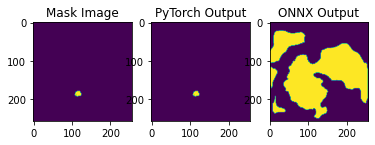

In [20]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(mask_image[:,:,100])
ax1.set_title('Mask Image')

ax2.imshow(pt_to_save[:,:,100])
ax2.set_title('PyTorch Output')

ax3.imshow(ort_to_save[:,:,100])
_ = ax3.set_title('ONNX Output')

In [14]:
from collections import Counter

mask_counts = Counter(mask_image.flatten())
pt_counts = Counter(pt_to_save.flatten())
ort_counts = Counter(ort_to_save.flatten())
print("mask_counts:", mask_counts)
print("pt_counts:", pt_counts)
print("ort_counts:", ort_counts)

mask_counts: Counter({0.0: 12579475, 1.0: 3437})
pt_counts: Counter({0.0: 12579475, 1.0: 3437})
ort_counts: Counter({0.0: 10304443, 1.0: 2278469})
